# Parametric Survival Fit & PSA for Age-at-Onset in Autoimmune Disease: Generalized Gamma Workflow

## Background and Motivation

In rare disease research, published studies often report aggregate summary statistics (such as quartiles and sample size) rather than individual-level data. Despite this limitation, we can still estimate the underlying age-at-onset distribution using parametric survival models.

In this notebook, we fit parametric models (lognormal, Weibull, and generalized gamma) to reported summary statistics. We then use the best-fitting model to estimate age-band diagnosis proportions and propagate parameter uncertainty using probabilistic sensitivity analysis (PSA).

This approach is commonly used in epidemiological modeling and health economic models, where understanding the distribution of disease onset is essential for estimating clinical burden, quality-adjusted life years, and cost trajectories.

## Software and Dependencies


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, weibull_min, gamma, genextreme # Importing necessary libraries for statistical distributions 
from scipy.optimize import minimize # Optimization for parameter fitting
from scipy.stats import probplot # Probability plot for visual assessment
from sklearn.metrics import mean_squared_error # Mean Squared Error for goodness-of-fit
from scipy.stats import gaussian_kde # Kernel Density Estimation for smooth CDF
from scipy.stats import gengamma
from scipy.stats import gengamma, norm

## I. Fit Parametric Age-at-Onset Model

### 1. Summary Statistics Overview

The table below lists the summary statistics extracted from literature. These values represent the observed distribution of age at disease onset in the study population.

We will use the quartiles (Q1, median, Q3) as anchors for fitting our model, since they are stable summary measures that describe the shape of the distribution without requiring raw data.

In [58]:
median = 66
q1 = 61 
q3 = 72
min = 19
max = 88
mean = 67
size = 111

In [59]:

empirical_q = [q1, median, q3]

In [60]:
# Overview of the input data
data_summary = pd.DataFrame({
    'Statistic': ['Min', 'Q1', 'Median', 'Q3', 'Max', 'Mean', 'Size'],
    'Value': [min, q1, median, q3, max, mean, size]
})
print(data_summary)

  Statistic  Value
0       Min     19
1        Q1     61
2    Median     66
3        Q3     72
4       Max     88
5      Mean     67
6      Size    111


### 2. Fitting the Generalized Gamma Model

The generalized gamma distribution is flexible and can represent a wide range of shapes, making it useful when the underlying distribution is not known in advance.

To estimate the parameters, we use quantile matching:
- Compute the theoretical quartiles of the generalized gamma model.
- Adjust the parameters until those quartiles best match the reported Q1, median, and Q3.
- The optimizer searches for the parameter values that minimize the squared error between observed and model-predicted quantiles.

This gives us a fitted model that aligns well with the reported summary data, even though we do not have access to individual onset ages.

In [61]:
# Define the quantile-matching objective function
def gengamma_objective(params):
    a, c, scale = params
    if a <= 0 or scale <= 0:
        return np.inf
    try:
        dist = gengamma(a=a, c=c, scale=scale)
        theo_q = dist.ppf([0.25, 0.5, 0.75])
        return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
    except:
        return np.inf

In [62]:
# Run the optimization
initial_guess_gengamma = [2.0, 1.0, 10.0]
bounds_gengamma = [(0.01, None), (0.01, None), (0.01, None)]

result_gengamma = minimize(gengamma_objective, x0=initial_guess_gengamma, bounds=bounds_gengamma)
a_fit_gengamma, c_fit_gengamma, scale_fit_gengamma = result_gengamma.x


/var/folders/b8/9ymtxc2j7rb00xx34s753cwc0000gn/T/ipykernel_72089/1451994867.py:9: RuntimeWarning: overflow encountered in square
  return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [63]:

print(f"Fitted Generalized Gamma parameters: a={a_fit_gengamma}, c={c_fit_gengamma}, scale={scale_fit_gengamma}")

Fitted Generalized Gamma parameters: a=26.611036258227774, c=1.5834959593234883, scale=8.40915196992153


### 3. Model Fit Diagnostics

After fitting the model, we check whether the simulated ages resemble the reported data.
- The histogram shows whether the model captures the overall shape of the distribution.
- The CDF comparison allows us to verify alignment at key probability points such as Q1, median, Q3, min and max values.

If the model CDF passes near the observed probability points, the distribution fit is considered reasonable.

This visual confirmation complements numerical error measures and helps ensure the model is not misrepresenting the data.

In [64]:
# Simulate onset ages 
sim_ages_gengamma = gengamma(a = a_fit_gengamma, c = c_fit_gengamma, scale = scale_fit_gengamma).rvs(10000)

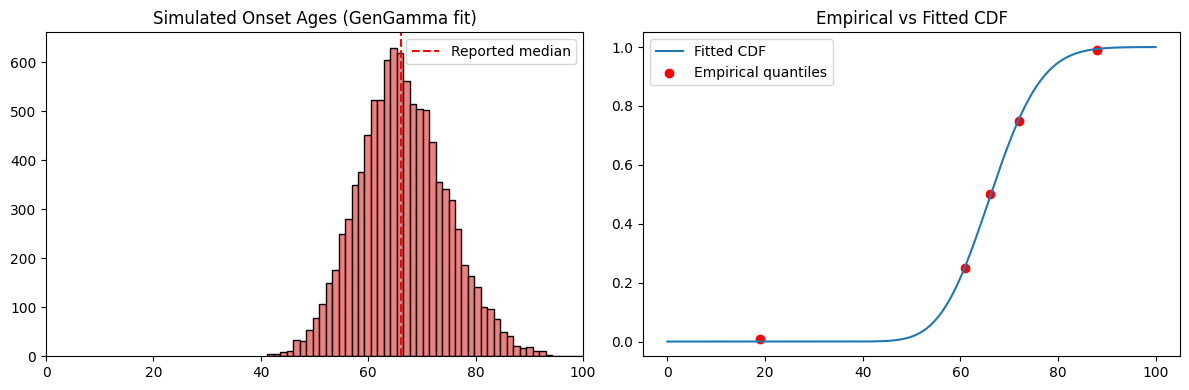

In [65]:
# Plot histogram and CDF
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

# Histogram
ax[0].hist(sim_ages_gengamma, bins=50, color='lightcoral', edgecolor='black')
ax[0].axvline(x=median, color='red', linestyle='--', label='Reported median')
ax[0].set_title('Simulated Onset Ages (GenGamma fit)')
ax[0].set_xlim(0, 100)
ax[0].legend()

# CDF
x_gengamma = np.linspace(0, 100, 300)
model_cdf_gengamma = gengamma(a=a_fit_gengamma, c=c_fit_gengamma, scale=scale_fit_gengamma).cdf(x_gengamma)
ax[1].plot(x_gengamma, model_cdf_gengamma, label='Fitted CDF')
ax[1].scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical quantiles')
ax[1].set_title('Empirical vs Fitted CDF')
ax[1].legend()

plt.tight_layout()
plt.show()


The histogram shows that the simulated median aligns closely with the reported median, suggesting that the fitted model captures the central tendency well.

## II. Probabilistic Sensitivity Analysis (PSA)

### 4. PSA Setup: Variance-Covariance, MVN Sampling, and Constraint

The parameters we estimated are not known with certainty—they are themselves estimates.

To reflect this uncertainty in our outputs, we perform Monte Carlo sampling:
1. We approximate the uncertainty in the estimated parameters using the variance-covariance matrix.
2. We draw many possible parameter sets from a multivariate normal distribution.
3. For each draw, we compute the implied age-at-onset distribution.

This allows us to measure how uncertainty in model parameters affects the age-band symptom onset proportions.

Rather than giving a single point estimate, we obtain a distribution of possible values for each age band.

In [66]:
# The fitted model object from previous analysis
result_gengamma

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.10243077858152738
        x: [ 2.661e+01  1.583e+00  8.409e+00]
      nit: 88
      jac: [-1.463e-02  1.069e+00 -8.571e-02]
     nfev: 456
     njev: 114
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [67]:
# Get the MLE
theta_hat = result_gengamma.x

print(theta_hat)

[26.61103626  1.58349596  8.40915197]


Compute the Hessian numerically at the optimum

In [68]:
import numpy as np
from statsmodels.tools.numdiff import approx_hess

H = approx_hess(theta_hat, gengamma_objective)  # by default, central differences

In [69]:
# Invert the Hessian to get the variance-covariance matrix
vcov_matrix = np.linalg.inv(H)

print(vcov_matrix)

[[ 5.95129550e+02 -1.77608293e+01 -3.15062237e+02]
 [-1.77608293e+01  5.51055889e-01  9.63377691e+00]
 [-3.15062237e+02  9.63377691e+00  1.69340808e+02]]


In [70]:
# Multivariate normal sampling on fitted scale

from numpy.random import default_rng
rng = default_rng(123)
N = 5000

m = theta_hat  # MLE parameter vector
L = np.linalg.cholesky(vcov_matrix)  # Cholesky decomposition of variance-covariance matrix
Z = rng.standard_normal((N, len(m)))  # Standard normal samples

theta_draws = m + Z @ L.T  # MVN samples of parameters
mu_draws, log_sigma_draws, Q_draws = theta_draws.T

In [71]:
np.mean(log_sigma_draws)

1.5637918813315672

### 5. Age-Band Probabilities

Using the fitted distribution, we calculate the probability that disease onset occurs within three age ranges:
- 0–12 years
- 12–18 years
- 18+ years

We calculate these probabilities from the cumulative distribution function (CDF), which avoids needing to resample individual onset ages.

In [72]:
# Age bands (inclusive of lower, exclusive of upper)
age_bands = [(0, 12), (12, 18), (18, 100)]

In [73]:
# Compute band probabilities for each parameter set via CDF
def band_probs_for_draw(a, c, s):
    F = gengamma(a=a, c=c, scale=s).cdf
    p0_12 = F(12.0) - F(0.0)
    p12_18 = F(18.0) - F(12.0)
    p18_100 = F(100.0) - F(18.0)
    return p0_12, p12_18, p18_100

In [74]:
P = np.array([band_probs_for_draw(a, c, s) for a, c, s in zip(mu_draws, log_sigma_draws, Q_draws)]) # Shape (N, 3)


In [75]:
# Filter out NaNs in all three columns
P = P[~np.isnan(P).any(axis=1)]

In [76]:
print(P[:10])

[[1.20059387e-02 7.33904212e-02 9.14603640e-01]
 [1.08145832e-25 8.45280534e-18 9.99985839e-01]
 [1.92092384e-12 1.54251855e-08 9.99999974e-01]
 [1.20756676e-18 5.23993223e-13 9.99994565e-01]
 [1.70337946e-27 3.55365476e-19 9.99994112e-01]
 [3.04377245e-19 1.99256162e-13 9.99996554e-01]
 [1.00000000e+00 2.01283434e-13 0.00000000e+00]
 [8.17154984e-16 4.93084700e-11 9.99937577e-01]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.02810919e-20 2.75611355e-14 9.99997395e-01]]


In [77]:
# Summarize reults
summary = pd.DataFrame({
    'Age Band': ['0-12', '12-18', '18+'],
    'Mean': np.char.mod('%.2f%%', P.mean(axis=0)*100),
    "SD": np.char.mod('%.2f%%', P.std(axis=0)*100),
    "Median": np.char.mod('%.2f%%', np.median(P, axis=0)*100),
    "CI Lower (2.5%)": np.char.mod('%.2f%%', np.percentile(P, 2.5, axis=0)*100),
    "CI Upper (97.5%)": np.char.mod('%.2f%%', np.percentile(P, 97.5, axis=0)*100)
})

print(summary)


  Age Band    Mean      SD   Median CI Lower (2.5%) CI Upper (97.5%)
0     0-12   2.67%  14.00%    0.00%           0.00%           44.47%
1    12-18   1.95%   9.41%    0.00%           0.00%           23.81%
2      18+  95.38%  18.45%  100.00%           9.54%          100.00%


The summary table shows mean, median, and 95% uncertainty intervals for each age band.

This format aligns with reporting expectations in epidemiological and health economic modeling.
- The 18+ group has the highest and most stable onset probability because the majority of cases in the data occurred in this age range.
- The 0–12 and 12–18 groups show wider uncertainty because these events are infrequent.

These results can now be directly incorporated into disease burden, cost-effectiveness, or forecast models.

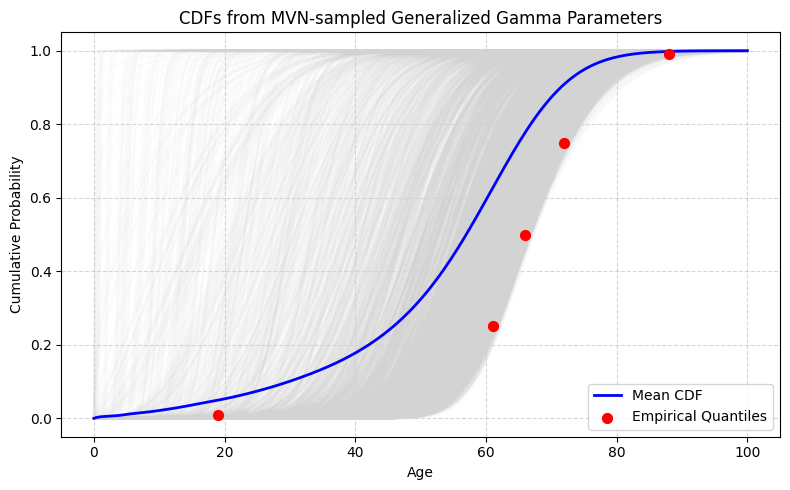

In [78]:
# Draw CDF for sampled parameters
x = np.linspace(0, 100, 300)
cdf_samples = [gengamma(a=a, c=c, scale=s).cdf(x) for a, c, s in zip(mu_draws, log_sigma_draws, Q_draws)]
import matplotlib.pyplot as plt
# Plot sampled CDFs
plt.figure(figsize=(8, 5))
for cdf in cdf_samples:
    plt.plot(x, cdf, color='lightgray', alpha=0.05)

# Plot mean CDF
mean_cdf = np.nanmean(cdf_samples, axis=0)
plt.plot(x, mean_cdf, color='blue', label='Mean CDF', linewidth=2)

# Plot empirical quantiles
plt.scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical Quantiles',
            zorder=10, s=50)

# Format plot
plt.title('CDFs from MVN-sampled Generalized Gamma Parameters')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


This figure visualizes the uncertainty in the cumulative distribution function (CDF) of age at disease onset, based on a generalized gamma model.
- Each light gray curve represents one CDF generated from a random draw of parameters (shape a, power c, scale s) from a multivariate normal (MVN) distribution. These captures parameter uncertainty from the model fitting step.
- The solid blue line is the mean CDF, summarizing the average cumulative probability across all 5,000 Monte Carlo simulations.
- The red dots represent empirical quantiles (e.g., min ≈ 19, Q1 = 61, median = 66, Q3 = 72, max = 88) obtained directly from the study dataset or publication. They serve as reference points for validation — showing how well the model reproduces observed data.

The blue mean curve closely tracks the red dots (empirical quantiles), indicating that the generalized gamma model fits the data well.

The steep middle section (ages ~55–75) reflects a rapid increase in cumulative probability — meaning that most disease onsets cluster around these ages.

The flat tails on both ends (near age 0–20 and 85–100) imply few very early or very late onsets.

In other words, the model predicts that: ~50% of cases occur before ~66 years old, and ~75% before ~72 years old, with most diagnoses concentrated in mid-to-late adulthood.

### What It Teaches About MVN Sampling and PSA

This plot visually demonstrates the concept of probabilistic sensitivity analysis (PSA):
- Each gray CDF corresponds to one Monte Carlo draw from the multivariate normal distribution of parameters (obtained via Cholesky decomposition).
- Instead of a single deterministic curve, we obtain a distribution of possible CDFs — reflecting realistic uncertainty in parameter estimates.
- The spread of curves shows how sensitive model outputs (diagnosis probability by age) are to parameter variability.

This approach allows:
- Computing credible intervals (e.g., 95% CI for diagnosis proportions in specific age bands), and
- Integrating uncertainty directly into downstream epidemiological or cost-effectiveness analyses.

## Software Versions for Reproducibility

Finally, we report package versions and environment details.
This enables collaborators or reviewers to reproduce the model fits exactly.

In [ ]:
import sys
import platform
import numpy as np
import pandas as pd
import scipy
import statsmodels
import matplotlib

print("Python:", sys.version.split()[0])
print("Platform:", platform.system(), platform.release())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("SciPy:", scipy.__version__)
print("Statsmodels:", statsmodels.__version__)
print("Matplotlib:", matplotlib.__version__)

Python: 3.12.2
Platform: Darwin 24.6.0
NumPy: 1.26.4
Pandas: 2.2.3
SciPy: 1.13.1
Statsmodels: 0.14.2
Matplotlib: 3.9.2
